<a href="https://colab.research.google.com/github/itberrios/algotrading/blob/main/descriptive_analytics/motifs/motifs_aapl_15min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Motif Analysis for Apple Stock**

In this notebook we will search for motifs in the Apple training data

## Install libraries

In [ ]:
!pip install pandas_ta

In [ ]:
!pip install stumpy

In [ ]:
!pip install tslearn

## Base Library Import

In [5]:
import os
import re
from glob import glob
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

## Get The data

We will only work with AAPL data in this notebook

In [8]:
get_name = lambda x : re.search('\w+(?=_15min)', x).group()

In [ ]:
!git clone https://github.com/itberrios/algotrading

In [11]:
df = pd.read_csv(r'algotrading/data/clean/AAPL_15min_clean.csv', index_col=0)
df.shape

(13267, 5)

In [20]:
# get roughly 14 months of training data
train_df = df.iloc[:8000, :]

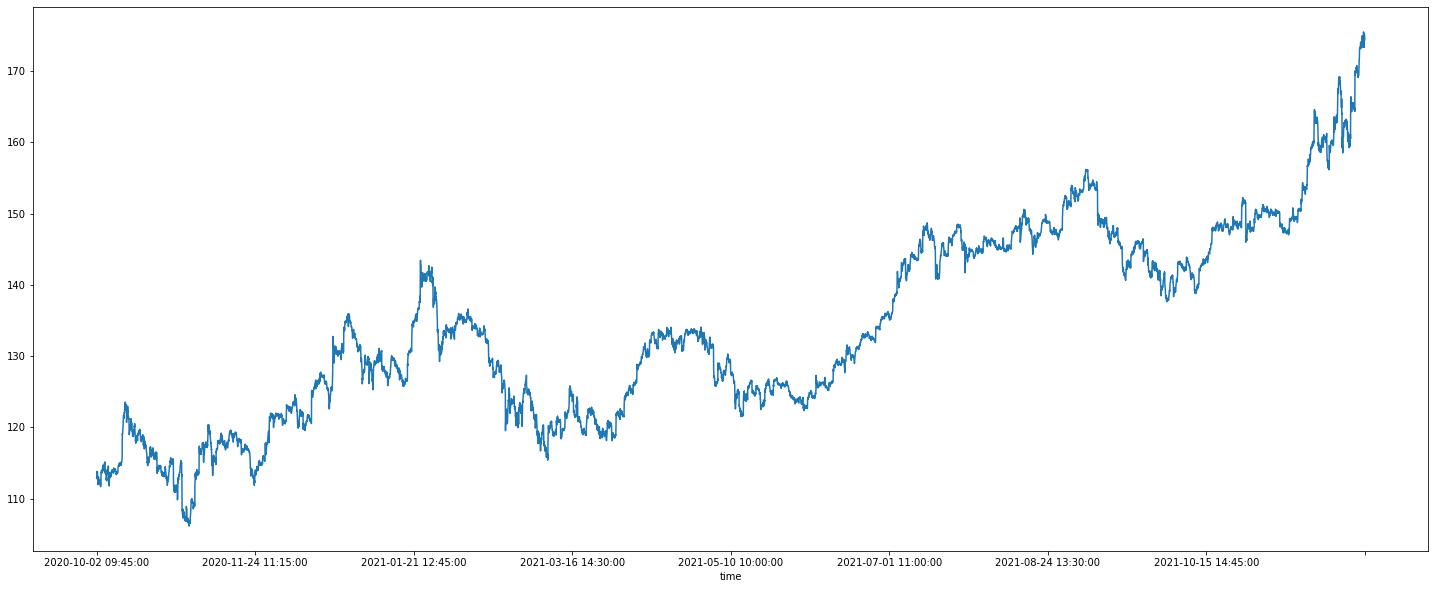

In [23]:
train_df['close'].plot(figsize=(25, 10));

## **Perform Motif Search**

For the Motif Search, we will use [STUMPY](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html) which is a powerful library that can efficiently search through large datasets.

For the initial search, we will make the hypothesis that Motifs or similar events may occur over a period of 4 hours, while sampling at a 15min interval. This means that we will use 16 time samples for our window_4hr size

In [170]:
import stumpy

window_4hr = 16 
matrix_profile_4hr = stumpy.stump(train_df['close'].sort_index(), m=window_4hr)

In [171]:
motif_idx = np.argsort(matrix_profile_4hr[:, 0])[0]
nearest_neighbor_idx = matrix_profile_4hr[motif_idx, 1]

Collect the dominant motifs that were discovered. We will try to collect a lot of them so we can cluster them later. Note that we will remove closely spaced motifs to we don't get a false sense of pattern formation. i.e. motifs within +/-5 will usually have strong matches even if they do not form any kind of unique pattern.

NOTE: We also need to clean motifs that do not take place over a continuous run, i.e. a motif that begins on one day and ends on the next day, these need to be removed.

In [172]:
# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []
useful_motif_indexes = []

# threshold for similar motifs spaced in time 
thresh = 12

i = 0
while i < matrix_profile_4hr.shape[0]:
    # get motifs
    motif_idx = np.argsort(matrix_profile_4hr[:, 0])[i]
    nearest_neighbor_idx = matrix_profile_4hr[motif_idx, 1]

    if i == 0:
        useful_motif_indexes.append(motif_idx)

        # store motif index
        motif_indexes.append(motif_idx)

        # increment i
        i += 1

        continue
    
    # remove closely spaced motifs
    if (np.min(np.abs(motif_idx - np.array(motif_indexes))) > thresh):
        useful_motif_indexes.append(motif_idx)

    # store motif index
    motif_indexes.append(motif_idx)
    
    # increment i
    i += 1

In [173]:
len(useful_motif_indexes)

276

We will now gather the clean motifs that do not have instances that fall outside of a single trading day. We will use 3 15min samples to see how the stock price behaves before and after the motif. Since the extended motif is more likely to fall outside of the day window_4hr, we will use a flag to indicate whether it does or not.

In [176]:
motifs = []
motif_idxs = []
ext_motifs = []
ext_outside = [] # indicates if extended motif is outside of the day window_4hr

# motif extension window_4hr
ext_wind = 3

for motif_idx in useful_motif_indexes:
    nearest_neighbor_idx = matrix_profile_4hr[motif_idx, 1]
    motif = train_df['close'].iloc[nearest_neighbor_idx:nearest_neighbor_idx + window_4hr]
    ext_motif = train_df['close'].iloc[nearest_neighbor_idx - ext_wind:nearest_neighbor_idx + window_4hr + ext_wind]

    # only include motifs that take place over the course of multiple days
    if len(pd.to_datetime(motif.index).dayofweek.unique()) == 1:
        motifs.append(motif.to_numpy())
        motif_idxs.append(nearest_neighbor_idx) # start index of motif
        ext_motifs.append(ext_motif.to_numpy())

        # get flag to determine if extended motif fall outside of the day window_4hr
        if len(pd.to_datetime(ext_motif.index).dayofweek.unique()) == 1:
            ext_outside.append(0)
        else:
            ext_outside.append(1)

motifs = np.array(motifs)
motif_idxs = np.array(motif_idxs)
ext_motifs = np.array(ext_motifs)
ext_outside = np.array(ext_outside)

## Plot Top 25 Motifs

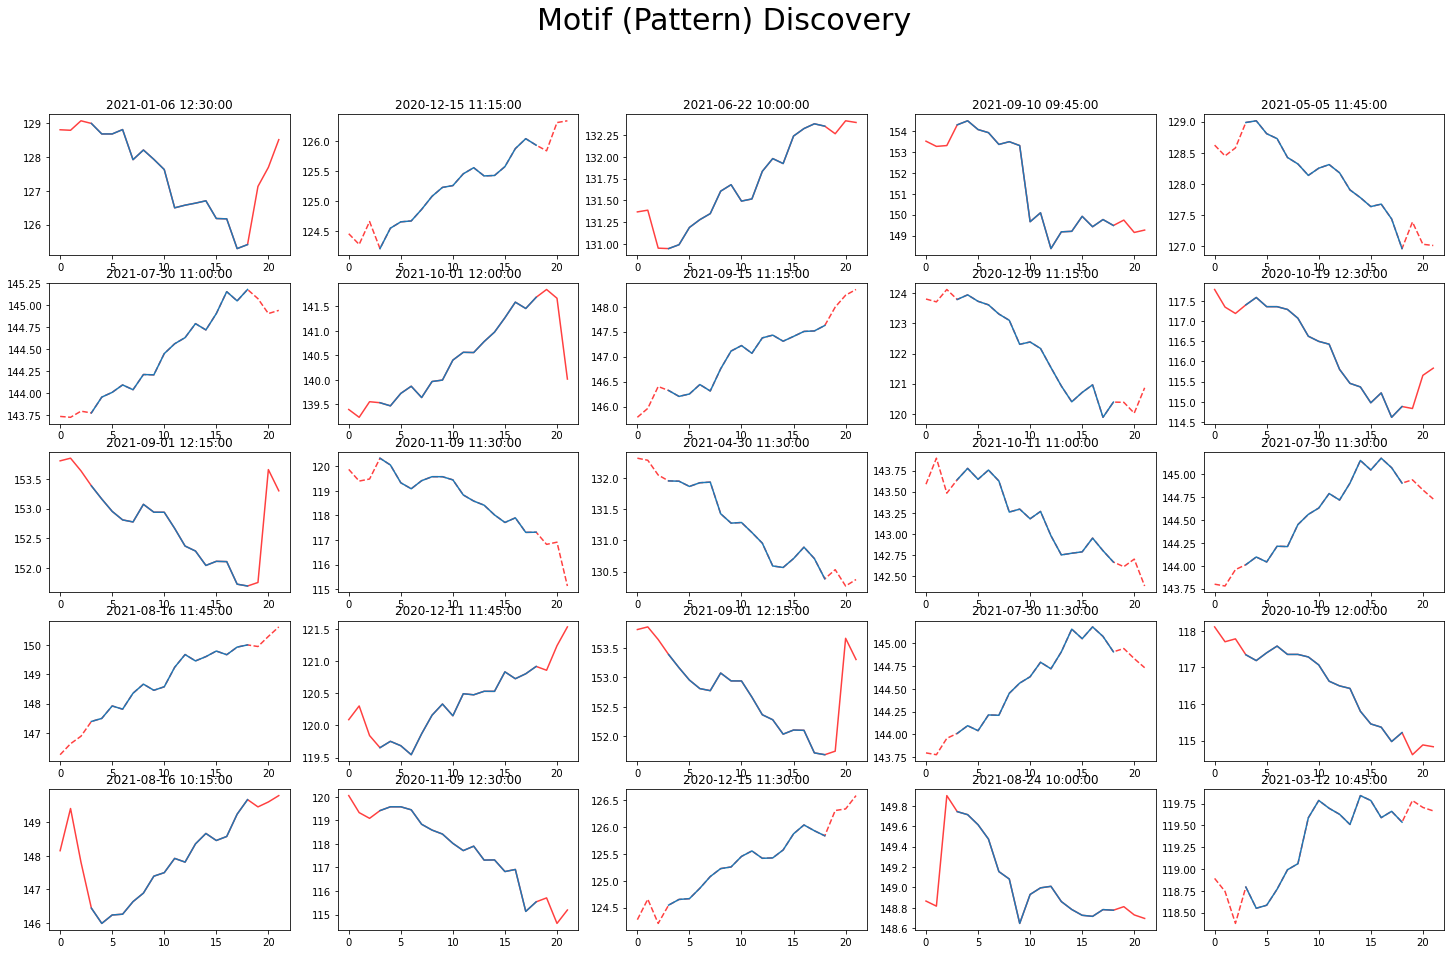

In [179]:
# display top 25 discovered motifs

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []

# threshold for similar motifs spacd in time 
thresh = 15

fig = plt.figure(figsize=(25, 15))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

i = 0
for i in range(25):
    plt.subplot(5, 5, 1 + i)

    # get motifs
    motif = motifs[i]
    m_idx = motif_idxs[i]
    ext_motif = ext_motifs[i]
    ext_out = ext_outside[i]


    # plot motif 
    if ext_out == 0:
        plt.plot(ext_motif, 'r--', alpha=0.75)
        plt.plot(np.arange(ext_wind, window_4hr + ext_wind), motif)
    else:
        plt.plot(ext_motif, 'r', alpha=0.75)
        plt.plot(np.arange(ext_wind, window_4hr + ext_wind), motif)

    
    plt.title(train_df['close'].index[m_idx])


The blue indicates the discovered Motif, the red indicates the next 3 15min time intervals, if the line is solid red, then the extension falls outside of the window_4hr. From these plots it looks like the large price movements in the extended window_4hr mainly occur when the extened motifs reaches beyond a single trading day

<br>
<br>

Now let's get the useful motifs, motifs that are dominant, and not close to eachother. We will now also remove motifs that take place over the course of more than one day

In [180]:
from tslearn.clustering import TimeSeriesKMeans

# get kmeans clustering object
n_clusters = 2
motif_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw",
                                max_iter=10, random_state=42)



In [181]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


motifs_tform = TimeSeriesScalerMeanVariance(mu=0., 
                                            std=1.).fit_transform(motifs) \
                                                   .squeeze()

In [182]:
motif_locs = motif_kmeans.fit_predict(motifs_tform)

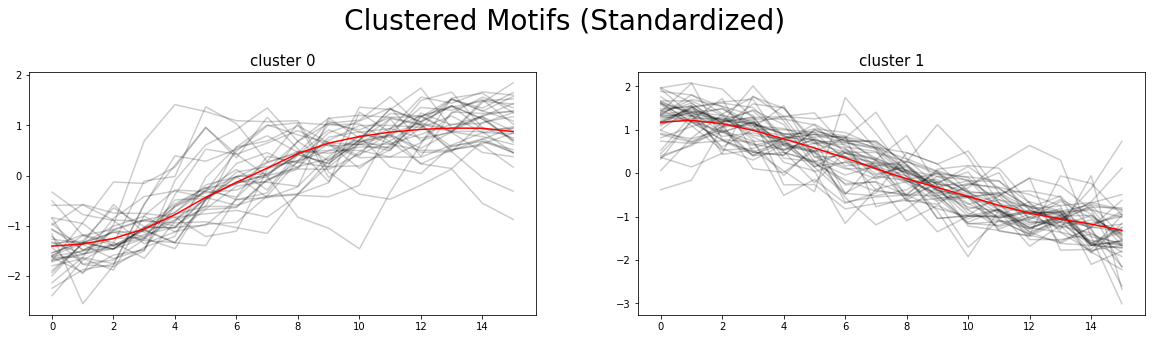

In [183]:
# display clusters
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Clustered Motifs (Standardized) \n', size=28)

for i in range(n_clusters):
    plt.subplot(1, n_clusters, 1 + i)
    for motif in motifs_tform[motif_locs == i]:
        plt.plot(motif.ravel(), 'k-', alpha=.2)
        plt.title(f'cluster {i}', size=15)

    plt.plot(motif_kmeans.cluster_centers_[i].ravel(), 'r-')

# lower plots to make space
plt.subplots_adjust(top=0.8)

In [184]:
print(f'cluster 1 size: {np.sum(motif_locs == 0)}')
print(f'cluster 2 size: {np.sum(motif_locs == 1)}')

cluster 1 size: 34
cluster 2 size: 45


These clustered motifs indicate that there are patterns of rising and falling prices throughout the data. We have 45 motifs indicating a downward trend and 34 motifs indicating an upward trend.

<br>
It would be interesting to see the 4 hour period before and after these patterns are discovered. Let's investigate

<br>

It would also be interesting to investigate more short term motifs, but it seems like there is a good price increase/decrease that takes place during this 4 hour window_4hr. So let's try a 2 hour window_4hr and see what happens.

In [168]:
window_2hr = 8 
matrix_profile_2hr = stumpy.stump(train_df['close'].sort_index(), m=window_2hr)

Get useful 2hr mmotifs

In [185]:
# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []
useful_motif_indexes = []

# threshold for similar motifs spaced in time 
thresh = 5

i = 0
while i < matrix_profile_2hr.shape[0]:
    # get motifs
    motif_idx = np.argsort(matrix_profile_2hr[:, 0])[i]
    nearest_neighbor_idx = matrix_profile_2hr[motif_idx, 1]

    if i == 0:
        useful_motif_indexes.append(motif_idx)

        # store motif index
        motif_indexes.append(motif_idx)

        # increment i
        i += 1

        continue
    
    # remove closely spaced motifs
    if (np.min(np.abs(motif_idx - np.array(motif_indexes))) > thresh):
        useful_motif_indexes.append(motif_idx)

    # store motif index
    motif_indexes.append(motif_idx)
    
    # increment i
    i += 1

In [186]:
len(useful_motif_indexes)

312

Filter motifs

In [187]:
motifs = []
motif_idxs = []
ext_motifs = []
ext_outside = [] # indicates if extended motif is outside of the day window_4hr

# motif extension window_4hr
ext_wind = 3

for motif_idx in useful_motif_indexes:
    nearest_neighbor_idx = matrix_profile_2hr[motif_idx, 1]
    motif = train_df['close'].iloc[nearest_neighbor_idx:nearest_neighbor_idx + window_2hr]
    ext_motif = train_df['close'].iloc[nearest_neighbor_idx - ext_wind:nearest_neighbor_idx + window_2hr + ext_wind]

    # only include motifs that take place over the course of multiple days
    if len(pd.to_datetime(motif.index).dayofweek.unique()) == 1:
        motifs.append(motif.to_numpy())
        motif_idxs.append(nearest_neighbor_idx) # start index of motif
        ext_motifs.append(ext_motif.to_numpy())

        # get flag to determine if extended motif fall outside of the day window_2hr
        if len(pd.to_datetime(ext_motif.index).dayofweek.unique()) == 1:
            ext_outside.append(0)
        else:
            ext_outside.append(1)

motifs = np.array(motifs)
motif_idxs = np.array(motif_idxs)
ext_motifs = np.array(ext_motifs)
ext_outside = np.array(ext_outside)

## Plot top 25 2 hr motifs

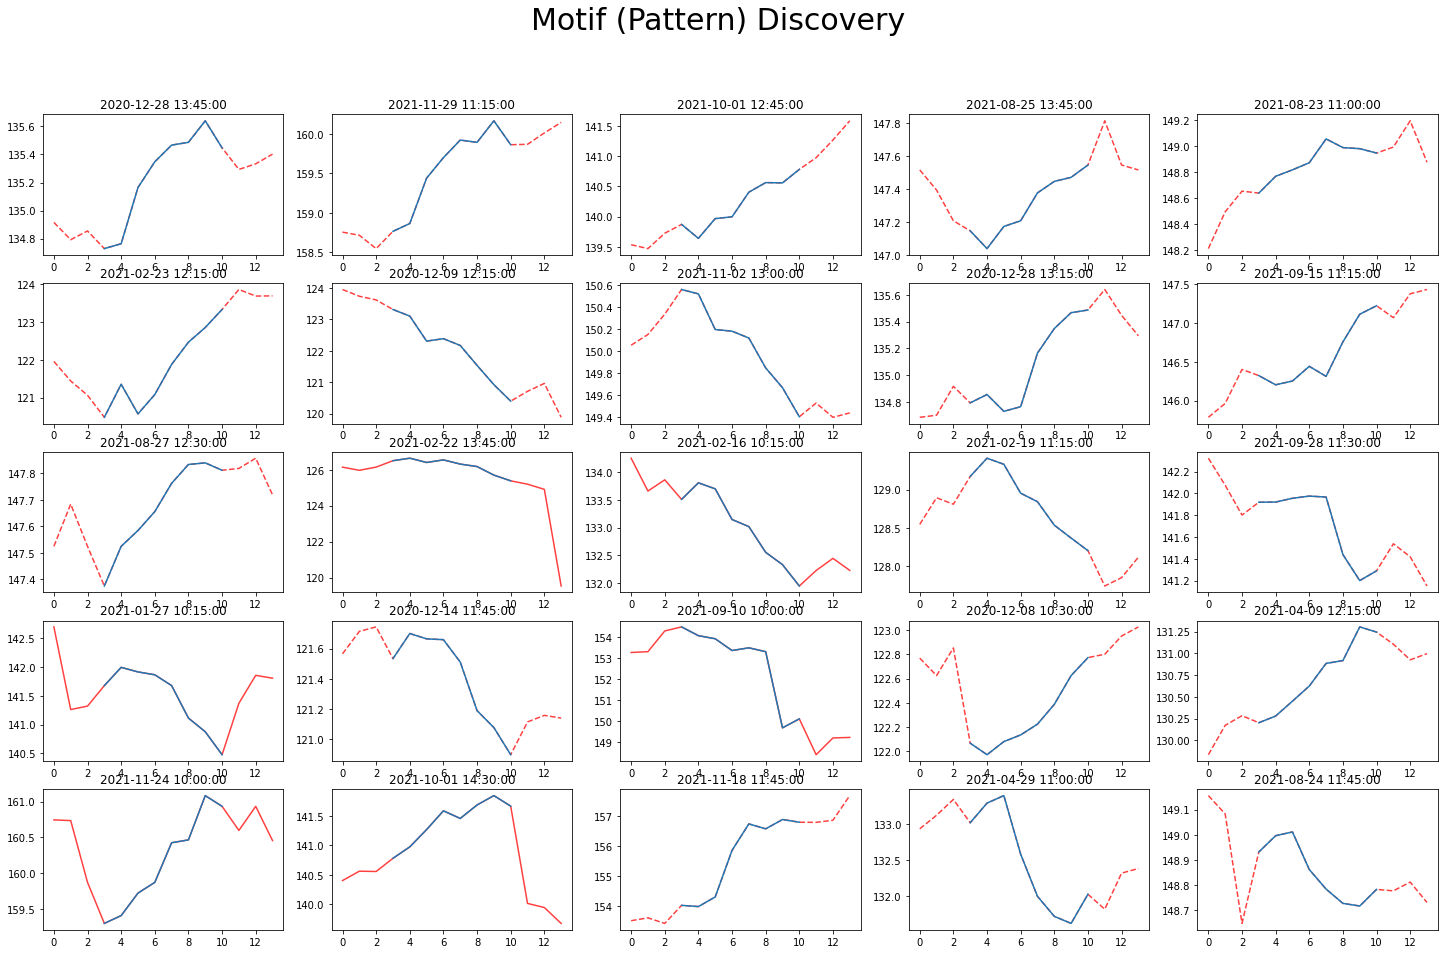

In [189]:
# display top 25 discovered motifs

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []


fig = plt.figure(figsize=(25, 15))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

i = 0
for i in range(25):
    plt.subplot(5, 5, 1 + i)

    # get motifs
    motif = motifs[i]
    m_idx = motif_idxs[i]
    ext_motif = ext_motifs[i]
    ext_out = ext_outside[i]


    # plot motif 
    if ext_out == 0:
        plt.plot(ext_motif, 'r--', alpha=0.75)
        plt.plot(np.arange(ext_wind, window_2hr + ext_wind), motif)
    else:
        plt.plot(ext_motif, 'r', alpha=0.75)
        plt.plot(np.arange(ext_wind, window_2hr + ext_wind), motif)

    
    plt.title(train_df['close'].index[m_idx])


In [195]:
# get kmeans clustering object
n_clusters = 5
motif_2hr_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw",
                                    max_iter=10, random_state=42)

In [196]:
motifs_tform = TimeSeriesScalerMeanVariance(mu=0., 
                                            std=1.).fit_transform(motifs) \
                                                   .squeeze()

In [197]:
motif_locs = motif_2hr_kmeans.fit_predict(motifs_tform)

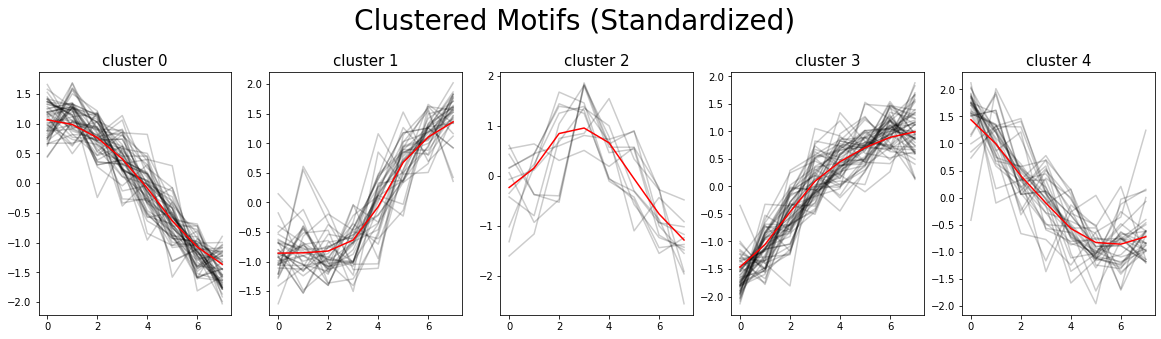

In [198]:
# display clusters
fig = plt.figure(figsize=(20, 5))
fig.suptitle('Clustered Motifs (Standardized) \n', size=28)

for i in range(n_clusters):
    plt.subplot(1, n_clusters, 1 + i)
    for motif in motifs_tform[motif_locs == i]:
        plt.plot(motif.ravel(), 'k-', alpha=.2)
        plt.title(f'cluster {i}', size=15)

    plt.plot(motif_2hr_kmeans.cluster_centers_[i].ravel(), 'r-')

# lower plots to make space
plt.subplots_adjust(top=0.8)

In [199]:
print(f'cluster 1 size: {np.sum(motif_locs == 0)}')
print(f'cluster 2 size: {np.sum(motif_locs == 1)}')
print(f'cluster 3 size: {np.sum(motif_locs == 2)}')
print(f'cluster 4 size: {np.sum(motif_locs == 3)}')
print(f'cluster 5 size: {np.sum(motif_locs == 4)}')

cluster 1 size: 52
cluster 2 size: 35
cluster 3 size: 12
cluster 4 size: 56
cluster 5 size: 32


In [201]:
52 + 32

84

We can see that their are 84 falling clusters and 91 rising clusters, indicating that trades can still be made during the 2 hour window. We count cluster 2 as an anomaly, since it is sparse and has a rise and fall within the 2 hour window